In [1]:
import torch
import torch.nn as nn
from torch import optim
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


In [2]:
df=pd.read_csv('/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv', parse_dates=['Datetime'])

In [3]:
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


### Checking Chronological Order and Equidistant Timestamps

In [4]:
df.isna().sum()
df=df.rename(columns={'Datetime':'date','PJMW_MW':'value'})
df
df['delta']=df['date']-df['date'].shift(1)#df.set_index('Datetime',inplace=True)

In [5]:
df['delta']

0                    NaT
1        0 days 01:00:00
2        0 days 01:00:00
3        0 days 01:00:00
4        0 days 01:00:00
               ...      
143201   0 days 01:00:00
143202   0 days 01:00:00
143203   0 days 01:00:00
143204   0 days 01:00:00
143205   0 days 01:00:00
Name: delta, Length: 143206, dtype: timedelta64[ns]

In [6]:
df=df.set_index('date')
df=df.sort_index()

In [7]:
df.drop(columns='delta',inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


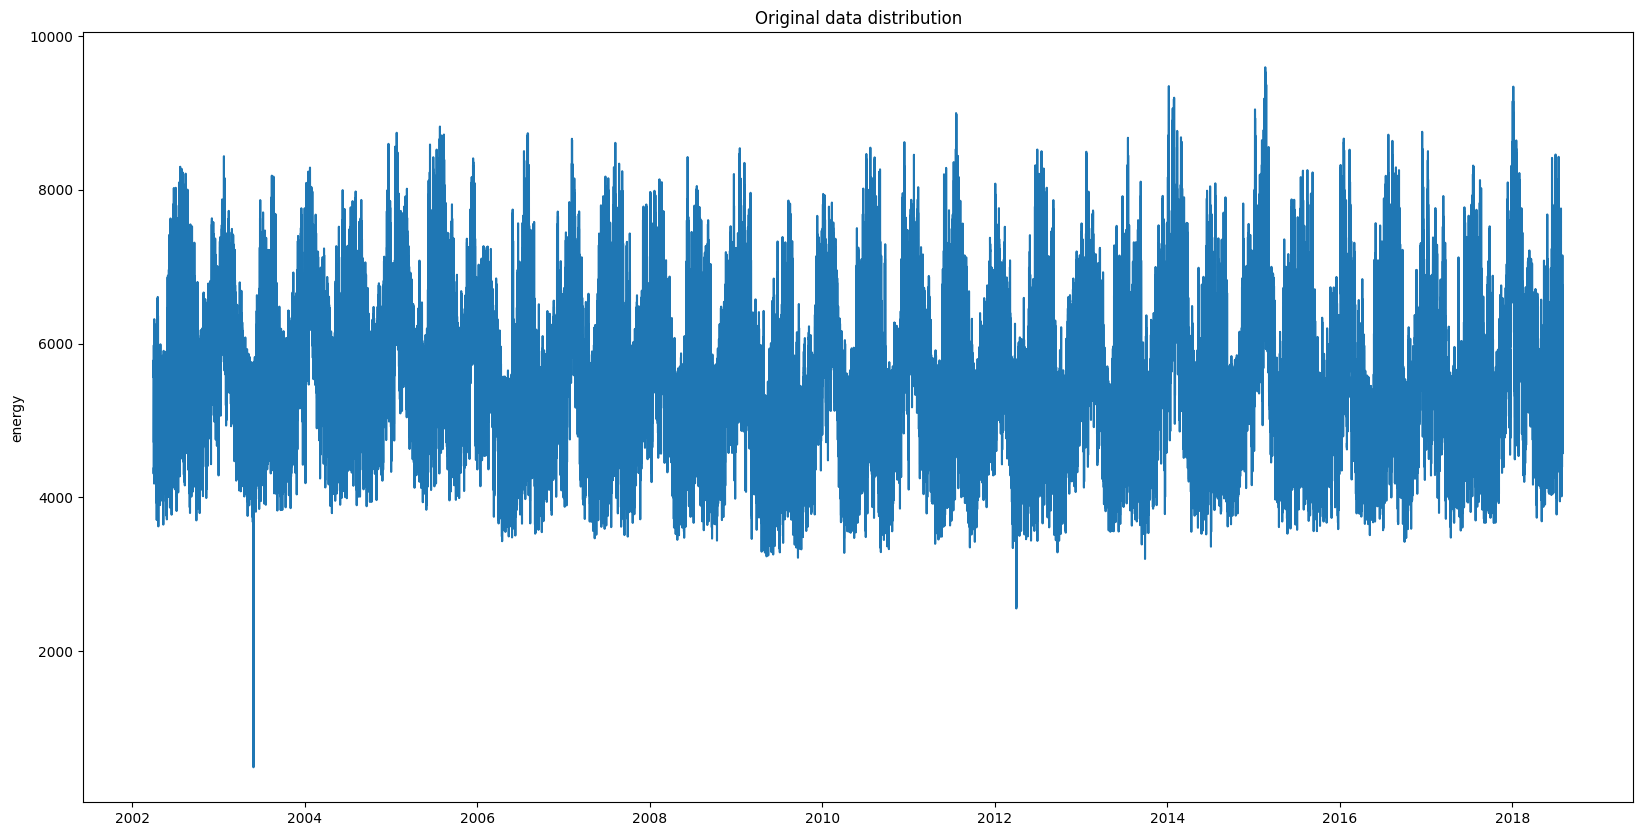

In [9]:
plt.figure(figsize=(20,10))
plt.plot(df)
plt.ylabel('energy')
plt.title('Original data distribution')
plt.show()

### Feature engineering
1. time lags
2. obtain more info from date index
3. encode features
4. make cyclical features
5. adding holidays

In [10]:
df.head()

,value
date,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


In [11]:
def generate_time_lags(df,n_lags):
    df_n=df.copy()
    for n in range(1,n_lags+1):
        df_n[f'lag{n}']=df_n['value'].shift(n)
    return df_n.iloc[n_lags:]

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
df_timelags.head()

,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,lag72,lag73,lag74,lag75,lag76,lag77,lag78,lag79,lag80,lag81,lag82,lag83,lag84,lag85,lag86,lag87,lag88,lag89,lag90,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-04-05 05:00:00,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,5852.0,5662.0,5582.0,5575.0,5649.0,5728.0,5795.0,5895.0,5972.0,6020.0,6048.0,6091.0,5922.0,5484.0,5109.0,5045.0,5021.0,5057.0,5112.0,5294.0,5639.0,6021.0,6220.0,6317.0,6009.0,5781.0,5677.0,5605.0,5653.0,5677.0,5599.0,5664.0,5624.0,5574.0,5517.0,5421.0,5063.0,4637.0,4258.0,4178.0,4225.0,4317.0,4452.0,4694.0,5017.0,5460.0,5728.0,5797.0,5466.0,5274.0,5228.0,5226.0,5300.0,5405.0,5470.0,5590.0,5662.0,5690.0,5742.0,5759.0,5567.0,5131.0,4809.0,4737.0,4713.0,4768.0,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,5272.0,5346.0,5425.0,5571.0,5637.0,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,4306.0,4374.0
2002-04-05 06:00:00,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,5852.0,5662.0,5582.0,5575.0,5649.0,5728.0,5795.0,5895.0,5972.0,6020.0,6048.0,6091.0,5922.0,5484.0,5109.0,5045.0,5021.0,5057.0,5112.0,5294.0,5639.0,6021.0,6220.0,6317.0,6009.0,5781.0,5677.0,5605.0,5653.0,5677.0,5599.0,5664.0,5624.0,5574.0,5517.0,5421.0,5063.0,4637.0,4258.0,4178.0,4225.0,4317.0,4452.0,4694.0,5017.0,5460.0,5728.0,5797.0,5466.0,5274.0,5228.0,5226.0,5300.0,5405.0,5470.0,5590.0,5662.0,5690.0,5742.0,5759.0,5567.0,5131.0,4809.0,4737.0,4713.0,4768.0,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,5272.0,5346.0,5425.0,5571.0,5637.0,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,4306.0
2002-04-05 07:00:00,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,5852.0,5662.0,5582.0,5575.0,5649.0,5728.0,5795.0,5895.0,5972.0,6020.0,6048.0,6091.0,5922.0,5484.0,5109.0,5045.0,5021.0,5057.0,5112.0,5294.0,5639.0,6021.0,6220.0,6317.0,6009.0,5781.0,5677.0,5605.0,5653.0,5677.0,5599.0,5664.0,5624.0,5574.0,5517.0,5421.0,5063.0,4637.0,4258.0,4178.0,4225.0,4317.0,4452.0,4694.0,5017.0,5460.0,5728.0,5797.0,5466.0,5274.0,5228.0,5226.0,5300.0,5405.0,5470.0,5590.0,5662.0,5690.0,5742.0,5759.0,5567.0,5131.0,4809.0,4737.0,4713.0,4768.0,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,5272.0,5346.0,5425.0,5571.0,5637.0,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0
2002-04-05 08:00:00,6240.0,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,5852.0,5662.0,5582.0,5575.0,5649.0,5728.0,5795.0,5895.0,5972.0,6020.0,6048.0,6091.0,5922.0,5484.0,5109.0,5045.0,5021.0,5057.0,5112.0,5294.0,5639.0,6021.0,6220.0,6317.0,6009.0,5781.0,5677.0,5605.0,5653.0,5677.0,5599.0,5664.0,5624.0,5574.0,5517.0,5421.0,5063.0,4637.0,4258.0,4178.0,4225.0,4317.0,4452.0,4694.0,5017.0,5460.0,5728.0,5797.0,5466.0,5274.0,5228.0,5226.0,5300.0,5405.0,5470.0,5590.0,5662.0,5690.0,5742.0,5759.0,5567.0,5131.0,4809.0,4737.0,4713.0,4768.0,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,5272.0,5346.0,5425.0,5571.0,5637.0,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0
2002-04-05 09:00:00,6113.0,6240.0,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,5852.0,5662.0,5582.0,5575.0,5649.0,5728.0,5795.0,5895.0,5972.0,6020.0,6048.0,6091.0,5922.0,5484.0,5109.0,5045.0,5021.0,5057.0,5112.0,5294.0,5639.0,6021.0,6220.0,6317.0,6009.0,5781.0,5677.0,5605.0,5653.0,5677.0,5599.0,5664.0,5624.0,5574.0,5517.0,5421.0,5063.0,4637.0,425

df_features = (
                df
                .assign(hour = df.index.hour)
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year = df.index.week)
              )
     

In [12]:
df_features = (
                df
                .assign(hour = df.index.hour)
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year = df.index.isocalendar().week)
              )
     

In [13]:
df_features[['value','hour']]

,value,hour
date,,
2002-04-01 01:00:00,4374.0,1
2002-04-01 02:00:00,4306.0,2
2002-04-01 03:00:00,4322.0,3
2002-04-01 04:00:00,4359.0,4
2002-04-01 05:00:00,4436.0,5
...,...,...
2018-08-02 20:00:00,6545.0,20
2018-08-02 21:00:00,6496.0,21
2018-08-02 22:00:00,6325.0,22


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(df, onehot_columns):
    ct = ColumnTransformer(
        [('onehot', OneHotEncoder(sparse_output=False), onehot_columns)],
        remainder='passthrough'
        ).set_output(transform="pandas")
    transformed=ct.fit_transform(df)
    
    return transformed

df_features1=onehot_encode(df_features,['month','day','day_of_week','week_of_year'])

In [15]:
df_features=pd.concat([df_features[['value','hour']],df_features1],axis=1)

In [16]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df_features = generate_cyclical_features(df_features, 'hour', 24, 0)
#df_features = generate_cyclical_features(df_features, 'day_of_week', 7, 0)
# df_features = generate_cyclical_features(df_features, 'month', 12, 1)
# df_features = generate_cyclical_features(df_features, 'week_of_year', 52, 0)

df_features.head()

,value,onehot__month_1,onehot__month_2,onehot__month_3,onehot__month_4,onehot__month_5,onehot__month_6,onehot__month_7,onehot__month_8,onehot__month_9,onehot__month_10,onehot__month_11,onehot__month_12,onehot__day_1,onehot__day_2,onehot__day_3,onehot__day_4,onehot__day_5,onehot__day_6,onehot__day_7,onehot__day_8,onehot__day_9,onehot__day_10,onehot__day_11,onehot__day_12,onehot__day_13,onehot__day_14,onehot__day_15,onehot__day_16,onehot__day_17,onehot__day_18,onehot__day_19,onehot__day_20,onehot__day_21,onehot__day_22,onehot__day_23,onehot__day_24,onehot__day_25,onehot__day_26,onehot__day_27,onehot__day_28,onehot__day_29,onehot__day_30,onehot__day_31,onehot__day_of_week_0,onehot__day_of_week_1,onehot__day_of_week_2,onehot__day_of_week_3,onehot__day_of_week_4,onehot__day_of_week_5,onehot__day_of_week_6,onehot__week_of_year_1.0,onehot__week_of_year_2.0,onehot__week_of_year_3.0,onehot__week_of_year_4.0,onehot__week_of_year_5.0,onehot__week_of_year_6.0,onehot__week_of_year_7.0,onehot__week_of_year_8.0,onehot__week_of_year_9.0,onehot__week_of_year_10.0,onehot__week_of_year_11.0,onehot__week_of_year_12.0,onehot__week_of_year_13.0,onehot__week_of_year_14.0,onehot__week_of_year_15.0,onehot__week_of_year_16.0,onehot__week_of_year_17.0,onehot__week_of_year_18.0,onehot__week_of_year_19.0,onehot__week_of_year_20.0,onehot__week_of_year_21.0,onehot__week_of_year_22.0,onehot__week_of_year_23.0,onehot__week_of_year_24.0,onehot__week_of_year_25.0,onehot__week_of_year_26.0,onehot__week_of_year_27.0,onehot__week_of_year_28.0,onehot__week_of_year_29.0,onehot__week_of_year_30.0,onehot__week_of_year_31.0,onehot__week_of_year_32.0,onehot__week_of_year_33.0,onehot__week_of_year_34.0,onehot__week_of_year_35.0,onehot__week_of_year_36.0,onehot__week_of_year_37.0,onehot__week_of_year_38.0,onehot__week_of_year_39.0,onehot__week_of_year_40.0,onehot__week_of_year_41.0,onehot__week_of_year_42.0,onehot__week_of_year_43.0,onehot__week_of_year_44.0,onehot__week_of_year_45.0,onehot__week_of_year_46.0,onehot__week_of_year_47.0,onehot__week_of_year_48.0,onehot__week_of_year_49.0,onehot__week_of_year_50.0,onehot__week_of_year_51.0,onehot__week_of_year_52.0,onehot__week_of_year_53.0,remainder__value,remainder__hour,sin_hour,cos_hour
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4374.0,1,0.258819,0.965926
2002-04-01 02:00:00,4306.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4306.0,2,0.500000,0.866025
2002-04-01 03:00:00,4322.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4322.0,3,0.707107,0.707107
2002-04-01 04:00:00,4359.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [17]:
import holidays



def is_holiday(datetime):
    us_holidays=holidays.US()
    return 1 if (datetime in us_holidays) else 0

def add_holiday_col(df):
    return df.assign(is_holiday=df.index.to_series().apply(is_holiday))

df_features=add_holiday_col(df_features)

In [18]:
df_features.head()

,value,onehot__month_1,onehot__month_2,onehot__month_3,onehot__month_4,onehot__month_5,onehot__month_6,onehot__month_7,onehot__month_8,onehot__month_9,onehot__month_10,onehot__month_11,onehot__month_12,onehot__day_1,onehot__day_2,onehot__day_3,onehot__day_4,onehot__day_5,onehot__day_6,onehot__day_7,onehot__day_8,onehot__day_9,onehot__day_10,onehot__day_11,onehot__day_12,onehot__day_13,onehot__day_14,onehot__day_15,onehot__day_16,onehot__day_17,onehot__day_18,onehot__day_19,onehot__day_20,onehot__day_21,onehot__day_22,onehot__day_23,onehot__day_24,onehot__day_25,onehot__day_26,onehot__day_27,onehot__day_28,onehot__day_29,onehot__day_30,onehot__day_31,onehot__day_of_week_0,onehot__day_of_week_1,onehot__day_of_week_2,onehot__day_of_week_3,onehot__day_of_week_4,onehot__day_of_week_5,onehot__day_of_week_6,onehot__week_of_year_1.0,onehot__week_of_year_2.0,onehot__week_of_year_3.0,onehot__week_of_year_4.0,onehot__week_of_year_5.0,onehot__week_of_year_6.0,onehot__week_of_year_7.0,onehot__week_of_year_8.0,onehot__week_of_year_9.0,onehot__week_of_year_10.0,onehot__week_of_year_11.0,onehot__week_of_year_12.0,onehot__week_of_year_13.0,onehot__week_of_year_14.0,onehot__week_of_year_15.0,onehot__week_of_year_16.0,onehot__week_of_year_17.0,onehot__week_of_year_18.0,onehot__week_of_year_19.0,onehot__week_of_year_20.0,onehot__week_of_year_21.0,onehot__week_of_year_22.0,onehot__week_of_year_23.0,onehot__week_of_year_24.0,onehot__week_of_year_25.0,onehot__week_of_year_26.0,onehot__week_of_year_27.0,onehot__week_of_year_28.0,onehot__week_of_year_29.0,onehot__week_of_year_30.0,onehot__week_of_year_31.0,onehot__week_of_year_32.0,onehot__week_of_year_33.0,onehot__week_of_year_34.0,onehot__week_of_year_35.0,onehot__week_of_year_36.0,onehot__week_of_year_37.0,onehot__week_of_year_38.0,onehot__week_of_year_39.0,onehot__week_of_year_40.0,onehot__week_of_year_41.0,onehot__week_of_year_42.0,onehot__week_of_year_43.0,onehot__week_of_year_44.0,onehot__week_of_year_45.0,onehot__week_of_year_46.0,onehot__week_of_year_47.0,onehot__week_of_year_48.0,onehot__week_of_year_49.0,onehot__week_of_year_50.0,onehot__week_of_year_51.0,onehot__week_of_year_52.0,onehot__week_of_year_53.0,remainder__value,remainder__hour,sin_hour,cos_hour,is_holiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4374.0,1,0.258819,0.965926,0
2002-04-01 02:00:00,4306.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4306.0,2,0.500000,0.866025,0
2002-04-01 03:00:00,4322.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4322.0,3,0.707107,0.707107,0
2002-04-01 04:00:00,4359.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [19]:
def create_sequences(X, y, seq_length, horizon=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length - horizon + 1):
        # Extract sequences
        X_seq.append(X[i : i + seq_length])  # Features for the sequence
        y_seq.append(y[i + seq_length + horizon - 1])  # Target for prediction
    return np.array(X_seq, dtype='float32'), np.array(y_seq, dtype='float32')

#x,y=create_sequences(df_features.values,168)

### Train test split
1. scaling data according to train set
2. Adding time sequences of 1 week (168 hours)
3. Converting data into tensors for pytorch models

In [20]:
from sklearn.model_selection import train_test_split
X=df_features.drop(columns='value')
y=df_features[['value']]
print(len(X)),print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

143206
143206


In [21]:
X_train.head()

,onehot__month_1,onehot__month_2,onehot__month_3,onehot__month_4,onehot__month_5,onehot__month_6,onehot__month_7,onehot__month_8,onehot__month_9,onehot__month_10,onehot__month_11,onehot__month_12,onehot__day_1,onehot__day_2,onehot__day_3,onehot__day_4,onehot__day_5,onehot__day_6,onehot__day_7,onehot__day_8,onehot__day_9,onehot__day_10,onehot__day_11,onehot__day_12,onehot__day_13,onehot__day_14,onehot__day_15,onehot__day_16,onehot__day_17,onehot__day_18,onehot__day_19,onehot__day_20,onehot__day_21,onehot__day_22,onehot__day_23,onehot__day_24,onehot__day_25,onehot__day_26,onehot__day_27,onehot__day_28,onehot__day_29,onehot__day_30,onehot__day_31,onehot__day_of_week_0,onehot__day_of_week_1,onehot__day_of_week_2,onehot__day_of_week_3,onehot__day_of_week_4,onehot__day_of_week_5,onehot__day_of_week_6,onehot__week_of_year_1.0,onehot__week_of_year_2.0,onehot__week_of_year_3.0,onehot__week_of_year_4.0,onehot__week_of_year_5.0,onehot__week_of_year_6.0,onehot__week_of_year_7.0,onehot__week_of_year_8.0,onehot__week_of_year_9.0,onehot__week_of_year_10.0,onehot__week_of_year_11.0,onehot__week_of_year_12.0,onehot__week_of_year_13.0,onehot__week_of_year_14.0,onehot__week_of_year_15.0,onehot__week_of_year_16.0,onehot__week_of_year_17.0,onehot__week_of_year_18.0,onehot__week_of_year_19.0,onehot__week_of_year_20.0,onehot__week_of_year_21.0,onehot__week_of_year_22.0,onehot__week_of_year_23.0,onehot__week_of_year_24.0,onehot__week_of_year_25.0,onehot__week_of_year_26.0,onehot__week_of_year_27.0,onehot__week_of_year_28.0,onehot__week_of_year_29.0,onehot__week_of_year_30.0,onehot__week_of_year_31.0,onehot__week_of_year_32.0,onehot__week_of_year_33.0,onehot__week_of_year_34.0,onehot__week_of_year_35.0,onehot__week_of_year_36.0,onehot__week_of_year_37.0,onehot__week_of_year_38.0,onehot__week_of_year_39.0,onehot__week_of_year_40.0,onehot__week_of_year_41.0,onehot__week_of_year_42.0,onehot__week_of_year_43.0,onehot__week_of_year_44.0,onehot__week_of_year_45.0,onehot__week_of_year_46.0,onehot__week_of_year_47.0,onehot__week_of_year_48.0,onehot__week_of_year_49.0,onehot__week_of_year_50.0,onehot__week_of_year_51.0,onehot__week_of_year_52.0,onehot__week_of_year_53.0,remainder__value,remainder__hour,sin_hour,cos_hour,is_holiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4374.0,1,0.258819,0.965926,0
2002-04-01 02:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4306.0,2,0.500000,0.866025,0
2002-04-01 03:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4322.0,3,0.707107,0.707107,0
2002-04-01 04:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler


def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
    
scaler = get_scaler('minmax')

X_train_arr1 = scaler.fit_transform(X_train)
X_val_arr1 = scaler.transform(X_val)
X_test_arr1 = scaler.transform(X_test)

y_train_arr1 = scaler.fit_transform(y_train)
y_val_arr1 = scaler.transform(y_val)
y_test_arr1 = scaler.transform(y_test)

X_train_arr,y_train_arr=create_sequences(X_train_arr1,y_train_arr1,168)
X_val_arr,y_val_arr=create_sequences(X_val_arr1,y_val_arr1,168)
X_test_arr,y_test_arr=create_sequences(X_test_arr1,y_test_arr1,168)

In [23]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [24]:
data,label=next(iter(train_loader))

print(f'data shape: {data.shape}') #(batch,seq len,input dim/features)
print(f'label shape: {label.shape}')

data shape: torch.Size([64, 168, 108])
label shape: torch.Size([64, 1])


### Modelling

In [25]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNN, self).__init__()

        self.layer_dim=layer_dim
        self.hidden_dim=hidden_dim
        
        
        self.rnn=nn.RNN(input_size=input_dim,hidden_size=hidden_dim,num_layers=layer_dim,
                       batch_first=True,dropout=dropout_prob)

        self.fc1=nn.Linear(in_features=hidden_dim, out_features=output_dim)
        
    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        h_0 = torch.zeros( self.layer_dim,x.size(0),self.hidden_dim).to(device)

        out,h_0 = self.rnn(x,h_0.detach())

        out=out[:,-1,:] #extract the last time sequence

        x=self.fc1(out)
        #print(x.shape)
        return x


In [26]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTM, self).__init__()

        self.layer_dim=layer_dim
        self.hidden_dim=hidden_dim
        
        
        self.lstm=nn.LSTM(input_size=input_dim,hidden_size=hidden_dim,num_layers=layer_dim,
                       batch_first=True,dropout=dropout_prob)

        self.fc1=nn.Linear(in_features=hidden_dim, out_features=output_dim)
        
    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        h_0 = torch.zeros( self.layer_dim,x.size(0),self.hidden_dim).to(device)
        c_0 = torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).to(device)
        out,(h_0,c_0) = self.lstm(x,(h_0.detach(),c_0.detach()))

        out=out[:,-1,:] #extract the last time sequence

        x=self.fc1(out)

        return x

In [27]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRU, self).__init__()

        self.layer_dim=layer_dim
        self.hidden_dim=hidden_dim
        
        
        self.gru=nn.GRU(input_size=input_dim,hidden_size=hidden_dim,num_layers=layer_dim,
                       batch_first=True,dropout=dropout_prob)

        self.fc1=nn.Linear(in_features=hidden_dim, out_features=output_dim)
        
    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        h_0 = torch.zeros( self.layer_dim,x.size(0),self.hidden_dim).to(device)
        
        out,h_0 = self.gru(x,h_0.detach())

        out=out[:,-1,:] #extract the last time sequence

        x=self.fc1(out)

        return x

In [28]:
def get_model(model,params):
    models={'rnn':RNN,
           'lstm':LSTM,
           'gru':GRU}
    return models.get(model.lower())(**params)


In [29]:

class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self,model,loss_fn,optimizer):
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.train_loss=[] #for plotting
        self.valid_loss=[] #for plotting


    def train_step(self,X,y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            X (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        self.model.train()
        self.optimizer.zero_grad()
        yhat=self.model(X)
        loss = self.loss_fn(y, yhat)
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        
        
        #model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        for epoch in tqdm(range(1,n_epochs+1)):
            batch_losses=[]
            for _,(X,y) in enumerate(train_loader):
                X=X.reshape(batch_size,-1,n_features).to(device)
                y=y.to(device)
                loss=self.train_step(X,y)
                batch_losses.append(loss)
            training_loss=np.mean(batch_losses)
            self.train_loss.append(training_loss)
        
            with torch.inference_mode():
                batch_val_losses=[]
                self.model.eval()
                for _,(X,y) in enumerate(val_loader):
                    
                    X=X.reshape(batch_size,-1,n_features).to(device)
                    y=y.to(device)
                    yhat=self.model(X)
                    val_loss=self.loss_fn(y,yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss =np.mean(batch_val_losses)
                self.valid_loss.append(validation_loss)
                if (epoch <= 10) or (epoch % 50 == 0):
                    print(
                        f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                    )

        #torch.save(self.model.state_dict(), model_path)
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """

        
        self.model.eval()
        
        with torch.inference_mode():
            predictions=[]
            values=[]
            
            batch_val_losses=[]
            
            for _,(X,y) in enumerate(test_loader):
                    
                X=X.reshape(batch_size,-1,n_features).to(device)
                y=y.to(device)
                yhat=self.model(X)
                yhat=torch.Tensor.numpy(yhat.cpu())
                predictions.append(yhat)
                values.append(torch.Tensor.numpy(y.cpu()))
        return predictions,values        
        
    def plot_losses(self):
        plt.plot(self.train_loss,label='trainloss')
        plt.plot(self.valid_loss,label='validloss')
        plt.legend()
        plt.title('Losses')
        plt.show()
                     

In [30]:
64*4

256

In [31]:
def general_settings(model_name):
    input_dim=108
    hidden_dim=256
    layer_dim=3
    output_dim=1
    n_epochs=25
    batch_size=64
    dropout_prob=0.2
    #optim
    learning_rate = 0.0001
    weight_decay = 1e-6

    model_params={'input_dim': input_dim,
                 'hidden_dim':hidden_dim,
                 'layer_dim':layer_dim,
                 'output_dim':output_dim,
                 'dropout_prob':dropout_prob}

    model=get_model(model_name,model_params).to(device)
    
    loss_fn = nn.MSELoss(reduction="mean")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    opt=Optimization(model,loss_fn,optimizer)
    opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
    opt.plot_losses()
    predictions,values=opt.evaluate(test_loader_one,n_features=input_dim)
    return predictions,values
    

### Helper functions

In [32]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

def inverse_scaling(df,scaler):
    columns=df.columns
    for c in columns:
        df[c]=scaler.inverse_transform(df[[c]])
    return df


def formating_pred(values,predictions):
    
    p=np.concatenate(predictions,axis=0).ravel()
    v=np.concatenate(values,axis=0).ravel()
    df_result = pd.DataFrame(data={"value": v, "prediction": p},index=X_test.head(len(v)).index)
    df_result=inverse_scaling(df_result,scaler)
    return df_result

def plot_results(df):
    fig,ax=plt.subplots(1,1,figsize=(10,5))
    sns.lineplot(df,x=df.index,y='prediction',label='Predictions',c='red',ax=ax)
    sns.lineplot(df,x=df.index,y='value',label='Actual',ax=ax)
    ax.set_ylabel('energy')
    ax.set_title('test set data')
    plt.show()

def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'mape' : mean_absolute_percentage_error(df.value, df.prediction),
                     'r' :  r2_score(df.value,df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Mean Absolute Percentage Error:   ", result_metrics["mape"]*100,'%')
    print('R squared score:   ',result_metrics['r'])
    return result_metrics

In [33]:
def plot_results(df):
    fig,ax=plt.subplots(1,1,figsize=(10,5))
    sns.lineplot(df,x=df.index,y='prediction',label='Predictions',c='red',ax=ax)
    sns.lineplot(df,x=df.index,y='value',label='Actual',ax=ax)
    ax.set_ylabel('energy')
    ax.set_title('test set data')
    plt.show()


### Linear Regression

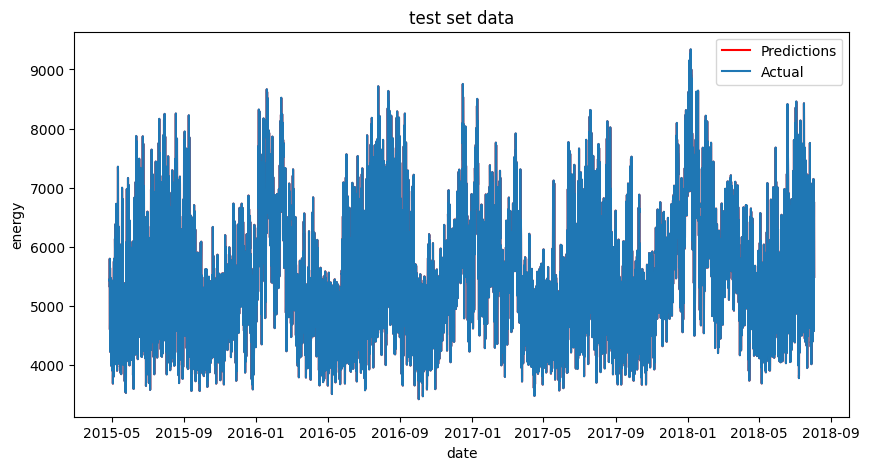

Mean Absolute Error:        1.2243994363818154
Mean Absolute Percentage Error:    0.02200240487124563 %
R squared score:    0.9999975387373263


{'mae': 1.2243994363818154,
 'mape': 0.0002200240487124563,
 'r': 0.9999975387373263}

In [34]:
from sklearn.linear_model import Ridge

ridge_model=Ridge()
ridge_model.fit(X_train_arr1,y_train_arr1)
pred=ridge_model.predict(X_test_arr1)
df_result=formating_pred(y_test_arr1,pred)
plot_results(df_result)
calculate_metrics(df_result)

### Random Forest Regressor

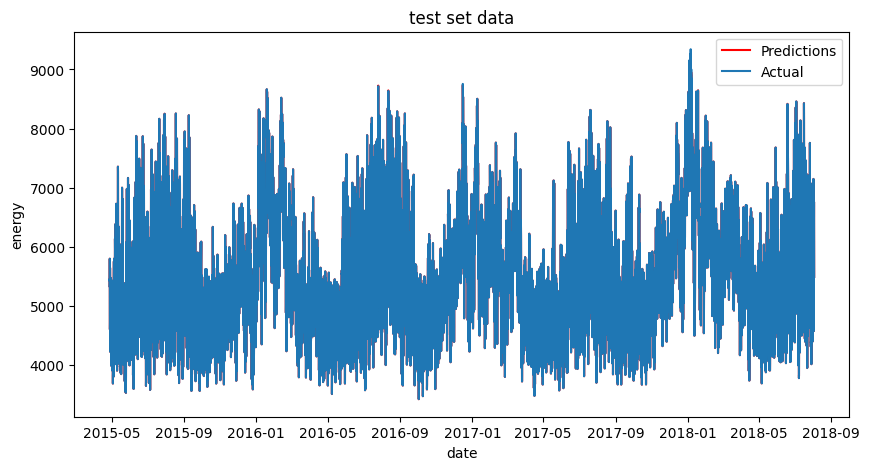

Mean Absolute Error:        0.1366294253194692
Mean Absolute Percentage Error:    0.001520474869563344 %
R squared score:    0.9999678581557596


{'mae': 0.1366294253194692,
 'mape': 1.520474869563344e-05,
 'r': 0.9999678581557596}

In [35]:
from sklearn.ensemble import RandomForestRegressor
random_forest=RandomForestRegressor()
random_forest.fit(X_train,y_train)
pred=random_forest.predict(X_test)
df_result = pd.DataFrame(data={"value": y_test.values.ravel(), "prediction": pred.ravel()},index=X_test.head(len(X_test)).index)
plot_results(df_result)
calculate_metrics(df_result)

### XGBoost 

[0]	validation_0-rmse:721.83469	validation_0-mean_absolute_error:578.70221
[1]	validation_0-rmse:506.84225	validation_0-mean_absolute_error:405.51529
[2]	validation_0-rmse:356.44233	validation_0-mean_absolute_error:284.21338
[3]	validation_0-rmse:251.09521	validation_0-mean_absolute_error:199.19945
[4]	validation_0-rmse:177.83726	validation_0-mean_absolute_error:139.72467
[5]	validation_0-rmse:126.83383	validation_0-mean_absolute_error:98.02164
[6]	validation_0-rmse:92.20683	validation_0-mean_absolute_error:69.02871
[7]	validation_0-rmse:68.32703	validation_0-mean_absolute_error:48.73360
[8]	validation_0-rmse:52.94531	validation_0-mean_absolute_error:34.71007
[9]	validation_0-rmse:42.93457	validation_0-mean_absolute_error:25.01034
[10]	validation_0-rmse:36.71648	validation_0-mean_absolute_error:18.34602
[11]	validation_0-rmse:32.89529	validation_0-mean_absolute_error:13.84441
[12]	validation_0-rmse:30.01242	validation_0-mean_absolute_error:10.85660
[13]	validation_0-rmse:28.67400	valid

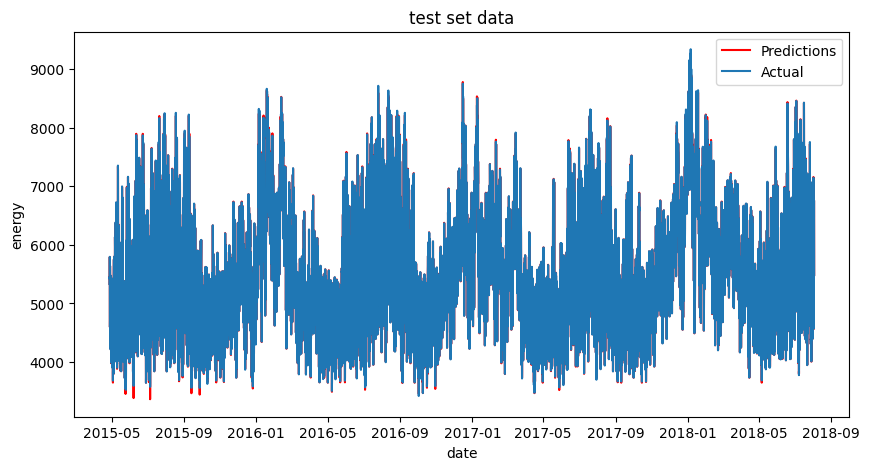

Mean Absolute Error:        4.913425443159303
Mean Absolute Percentage Error:    0.08749289418549168 %
R squared score:    0.999918162945365


{'mae': 4.913425443159303,
 'mape': 0.0008749289418549168,
 'r': 0.999918162945365}

In [36]:
from xgboost import XGBRegressor
reg = XGBRegressor(
    n_iterations=1000,
    early_stopping_rounds=100,
    eval_metric=mean_absolute_error,
    verbose=0
)
reg.fit(X, y, eval_set=[(X_val, y_val)])
pred=reg.predict(X_test)
df_result = pd.DataFrame(data={"value": y_test.values.ravel(), "prediction": pred.ravel()},index=X_test.head(len(X_test)).index)
plot_results(df_result)
calculate_metrics(df_result)

### Pytorch Models

  0%|          | 0/25 [00:00<?, ?it/s]

[1/25] Training loss: 0.0078	 Validation loss: 0.0157
[2/25] Training loss: 0.0053	 Validation loss: 0.0094
[3/25] Training loss: 0.0034	 Validation loss: 0.0070
[4/25] Training loss: 0.0031	 Validation loss: 0.0108
[5/25] Training loss: 0.0027	 Validation loss: 0.0075
[6/25] Training loss: 0.0022	 Validation loss: 0.0070
[7/25] Training loss: 0.0023	 Validation loss: 0.0055
[8/25] Training loss: 0.0019	 Validation loss: 0.0072
[9/25] Training loss: 0.0019	 Validation loss: 0.0047
[10/25] Training loss: 0.0018	 Validation loss: 0.0094


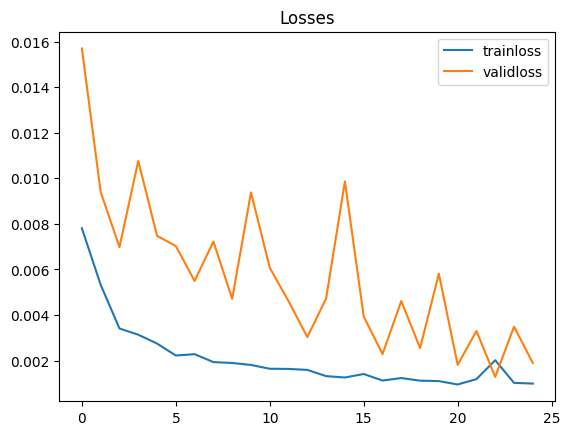

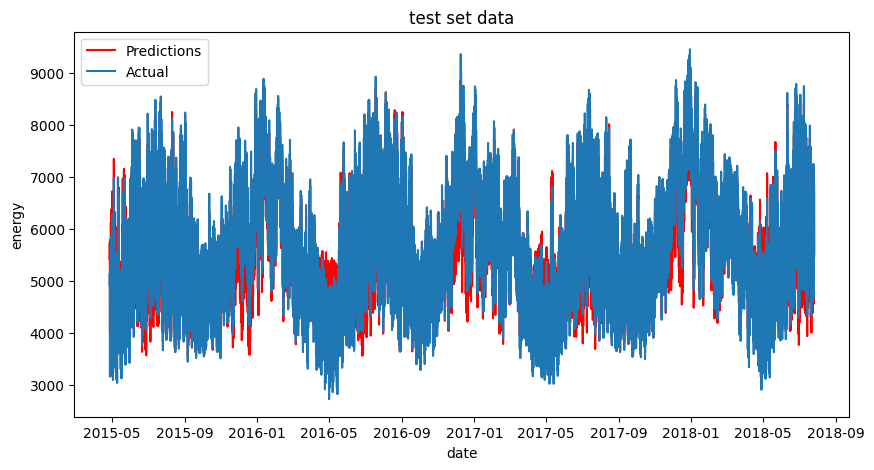

Mean Absolute Error:        287.48795
Mean Absolute Percentage Error:    5.1523275673389435 %
R squared score:    0.8960968289684832


{'mae': 287.48795, 'mape': 0.051523276, 'r': 0.8960968289684832}

In [37]:
pred,values=general_settings('rnn')
df_result=formating_pred(pred,values)
plot_results(df_result)
calculate_metrics(df_result)


  0%|          | 0/25 [00:00<?, ?it/s]

[1/25] Training loss: 0.0133	 Validation loss: 0.0099
[2/25] Training loss: 0.0058	 Validation loss: 0.0085
[3/25] Training loss: 0.0040	 Validation loss: 0.0074
[4/25] Training loss: 0.0038	 Validation loss: 0.0075
[5/25] Training loss: 0.0032	 Validation loss: 0.0060
[6/25] Training loss: 0.0029	 Validation loss: 0.0061
[7/25] Training loss: 0.0026	 Validation loss: 0.0061
[8/25] Training loss: 0.0026	 Validation loss: 0.0063
[9/25] Training loss: 0.0024	 Validation loss: 0.0063
[10/25] Training loss: 0.0021	 Validation loss: 0.0080


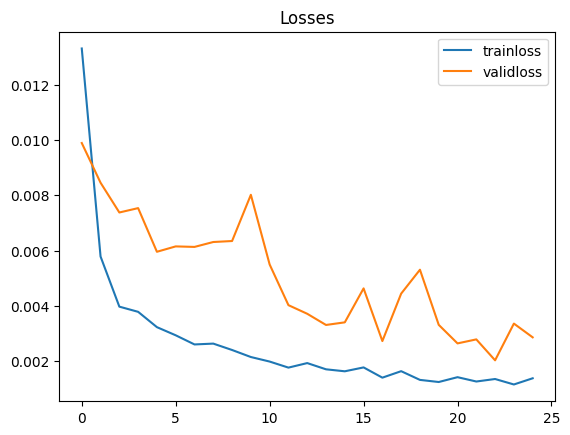

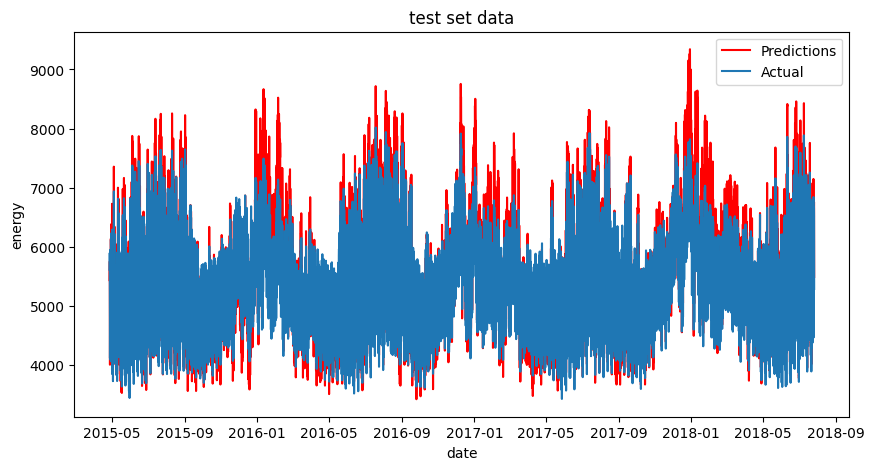

Mean Absolute Error:        291.7003
Mean Absolute Percentage Error:    5.287664011120796 %
R squared score:    0.7910626759032484


{'mae': 291.7003, 'mape': 0.05287664, 'r': 0.7910626759032484}

In [38]:
pred,values=general_settings('lstm')
df_result=formating_pred(pred,values)
plot_results(df_result)
calculate_metrics(df_result)


  0%|          | 0/25 [00:00<?, ?it/s]

[1/25] Training loss: 0.0113	 Validation loss: 0.0128
[2/25] Training loss: 0.0063	 Validation loss: 0.0091
[3/25] Training loss: 0.0041	 Validation loss: 0.0061
[4/25] Training loss: 0.0035	 Validation loss: 0.0054
[5/25] Training loss: 0.0030	 Validation loss: 0.0064
[6/25] Training loss: 0.0025	 Validation loss: 0.0049
[7/25] Training loss: 0.0023	 Validation loss: 0.0036
[8/25] Training loss: 0.0022	 Validation loss: 0.0036
[9/25] Training loss: 0.0018	 Validation loss: 0.0048
[10/25] Training loss: 0.0019	 Validation loss: 0.0048


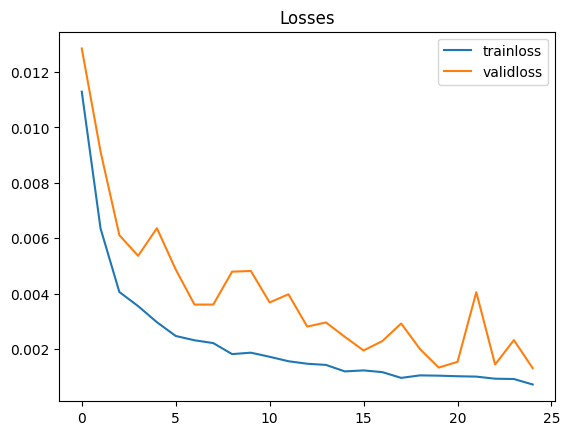

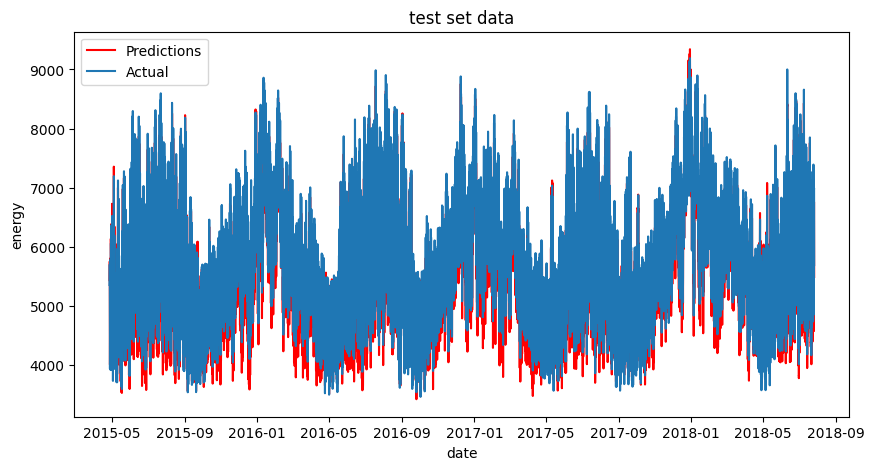

Mean Absolute Error:        283.16986
Mean Absolute Percentage Error:    4.866881296038628 %
R squared score:    0.8915985535463171


{'mae': 283.16986, 'mape': 0.048668813, 'r': 0.8915985535463171}

In [39]:
pred,values=general_settings('gru')
df_result=formating_pred(pred,values)
plot_results(df_result)
calculate_metrics(df_result)
